# Lead-Lag Path Augmentation Example

This notebook demonstrates how to create a lead-lag transformation using:
1. A Brownian motion driver
2. An Riemann-Liouville driver derived from the Brownian motion
3. A lead-lag path with Brownian leading and RL lagging following https://arxiv.org/abs/2412.21192

We will first compute a new correlated Brownian motions $\tilde{W}$ from two initial Brownians $\{ W_i \}_{i=0}^{n-1}, \{ B_i \}_{i=0}^{n-1}$ using the formula
$$
\tilde{W} = \rho dW_s + \sqrt{1 - \rho^2} dB_s.
$$

We will set our correlation parameter $\rho = -0.848$ following [1]


In [ ]:
import jax
import jax.numpy as jnp
from quicksig.rdes.drivers import bm_driver, correlate_bm_driver_against_reference
import matplotlib.pyplot as plt

rho = -0.848

timesteps = 1000
dim = 1

key = jax.random.key(1)
keys = jax.random.split(key, 2)

w_path = bm_driver(keys[0], timesteps, dim)
b_path = bm_driver(keys[1], timesteps, dim)

correlated_path = correlate_bm_driver_against_reference(w_path, b_path, rho)

Lets then plot the three Brownians we have generated and their correlations

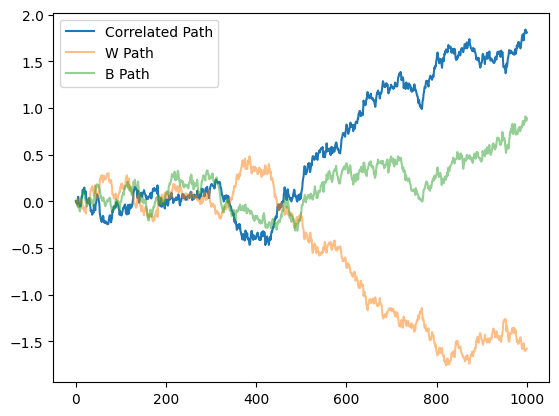

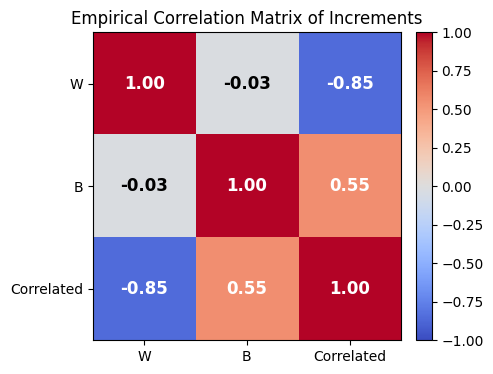

Empirical Correlation Matrix of Increments:
Corr(W, W) = 1.0000
Corr(W, B) = -0.0299
Corr(W, Correlated) = -0.8517
Corr(B, W) = -0.0299
Corr(B, B) = 1.0000
Corr(B, Correlated) = 0.5492
Corr(Correlated, W) = -0.8517
Corr(Correlated, B) = 0.5492
Corr(Correlated, Correlated) = 1.0000


In [ ]:
plt.plot(correlated_path.path, label="Correlated Path")
plt.plot(w_path.path, label="W Path", alpha=0.5)
plt.plot(b_path.path, label="B Path", alpha=0.5)
plt.legend()
plt.show()

# Compute increments
w_increments = jnp.diff(w_path.path, axis=0).flatten()
b_increments = jnp.diff(b_path.path, axis=0).flatten()
corr_increments = jnp.diff(correlated_path.path, axis=0).flatten()

# Stack increments for correlation matrix
increments_matrix = jnp.stack([w_increments, b_increments, corr_increments], axis=0)
emp_corr_matrix = jnp.corrcoef(increments_matrix)

# Plot the empirical correlation matrix with correlation coefficients
plt.figure(figsize=(5, 4))
im = plt.imshow(emp_corr_matrix, cmap="coolwarm", vmin=-1, vmax=1)
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.xticks([0, 1, 2], ["W", "B", "Correlated"])
plt.yticks([0, 1, 2], ["W", "B", "Correlated"])
plt.title("Empirical Correlation Matrix of Increments")

# Annotate correlation coefficients on the plot
for i in range(emp_corr_matrix.shape[0]):
    for j in range(emp_corr_matrix.shape[1]):
        plt.text(
            j, i, f"{emp_corr_matrix[i, j]:.2f}",
            ha="center", va="center",
            color="white" if abs(emp_corr_matrix[i, j]) > 0.5 else "black",
            fontsize=12, fontweight="bold"
        )

plt.show()

# Print the empirical correlations
print("Empirical Correlation Matrix of Increments:")
for i, row_name in enumerate(["W", "B", "Correlated"]):
    for j, col_name in enumerate(["W", "B", "Correlated"]):
        print(f"Corr({row_name}, {col_name}) = {emp_corr_matrix[i, j]:.4f}")



## Computing the Riemann-Liouville Process
As you can see above, we now have a new Brownian driver $\tilde{W}$ correlated to $W$ by $\rho$ and $B$ by $\sqrt{1 - \rho^2}$. We can then use $\tilde{W}$ to generate a Riemann Liouville process.

Calibration results from [1] recommend a Hurst parameter of $H=0.0996$, which is outside the range of $H$ which can be treated by rough paths. As such, we set $H=0.25$, the closest we can get while still converging under the rough path metric.

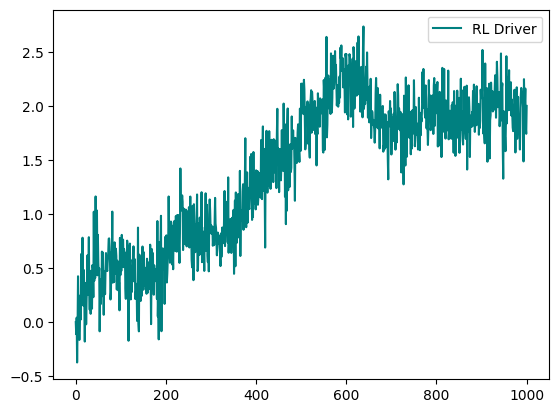

In [ ]:
from quicksig.rdes.drivers import riemann_liouville_driver

rl_driver = riemann_liouville_driver(key, timesteps, 0.25, correlated_path)
del b_path ## In the framework of [2], we no longer need the Brownian path B as we will control the volatility by the rl_driver and stock price by w_path

plt.plot(rl_driver, color="teal", label="RL Driver")
plt.legend()
plt.show()

## Forming the Lead-Lag Path
In the Framework of [2], we now form a lead-lag path, with the $W$ leading and the Riemann Liouville process lagging


In [ ]:
from quicksig.rdes.augmentations import lead_lag_augmentation

lead_lag_path = lead_lag_augmentation(w_path, rl_driver)

## References

[1] R. Callum, “The Rough Bergomi Model: From Motivation to Implemenetation,” Master’s Thesis, Imperial College London, London, 2023. [Online]. Available: https://www.imperial.ac.uk/media/imperial-college/faculty-of-natural-sciences/department-of-mathematics/math-finance/212261203---Callum-Rough---ROUGH_CALLUM_01333836.pdf
[2] O. Bonesini, E. Ferrucci, I. Gasteratos, and A. Jacquier, “Rough differential equations for volatility.” 2024. [Online]. Available: https://arxiv.org/abs/2412.21192